In [162]:
import xarray as xr
import rioxarray
from pathlib import Path
import rasterio
time_series_folder = '../output_folder/tests_area_cover'
nasa_stats_name = 'test_nasa.nc'
meteofrance_stats_name = 'test_mf.nc'

meteofrance_stats_path= Path(f"{time_series_folder}").joinpath(meteofrance_stats_name)
nasa_stats_path= Path(f"{time_series_folder}").joinpath(nasa_stats_name)

meteofrance_ds = xr.open_dataset(meteofrance_stats_path)
nasa_ds = xr.open_dataset(nasa_stats_path)

In [144]:
from typing import List
from matplotlib.axes import Axes
import pandas as pd

def print_table( year_stats_data_array: xr.DataArray, classes_to_print: List[str] | str = "all"):
    year_data_frame = year_stats_data_array.to_pandas()
    pd.options.display.float_format = "{:.3f}".format
    pd.options.display.precision = 3
    if classes_to_print == "all":
        classes_to_print = year_stats_data_array.coords["class_name"].values
    print(year_data_frame)

def classes_bar_distribution(
    year_stats_data_array: xr.DataArray, classes_to_plot: List[str] | str = "all", ax: Axes | None = None
) -> None:
    year_data_frame = year_stats_data_array.to_pandas()
    if classes_to_plot == "all":
        classes_to_plot = year_data_frame.index

    year_data_frame = year_data_frame.transpose()
    year_data_frame.index = year_data_frame.index.strftime("%B")
    year_data_frame[classes_to_plot].plot.bar(title=f"Class distribution for year ", ax=ax)


In [166]:
meteofrance_ds_unproj = xr.open_dataset( Path(f"{time_series_folder}").joinpath('test_mf_not_proj.nc'))

In [167]:
print_table(meteofrance_ds_unproj['class_distribution_percentage'])

time                 2023-01-01
class_name                     
snow_cover                0.484
no_snow                   4.400
clouds                   54.464
forest_without_snow       1.696
forest_with_snow          0.197
water                     2.807
nodata                   35.952


In [164]:
print_table(meteofrance_ds['class_distribution_percentage'])

time                 2023-01-01
class_name                     
snow_cover                5.208
no_snow                   5.019
clouds                   42.775
forest_without_snow       5.743
forest_with_snow          2.116
water                     0.089
nodata                   39.051


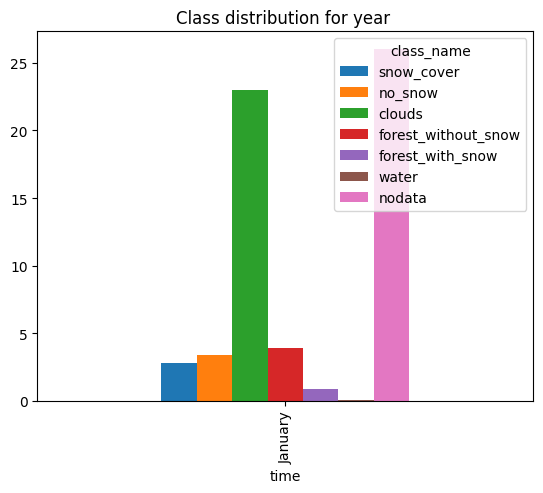

In [151]:
classes_bar_distribution(meteofrance_ds['class_distribution_area']*1e-9)

In [129]:
stats = xr.open_dataset('../output_folder/tests_area_cover/test_nasa.nc')

In [130]:
print(stats.data_vars['class_distribution_area'].to_pandas().sum())

time
2023-01-01    6.009885e+10
dtype: float64


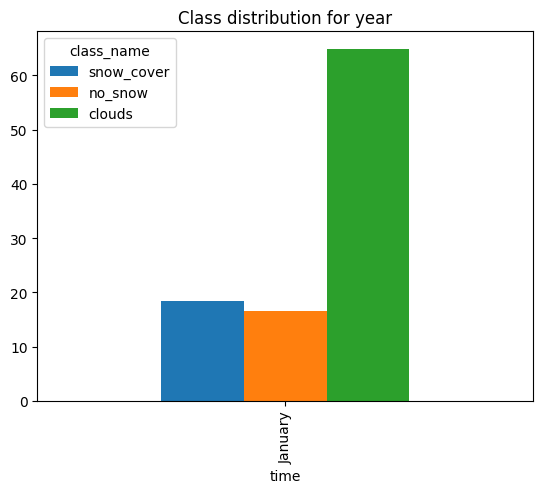

In [132]:
classes_bar_distribution(stats.data_vars['class_distribution_percentage'], classes_to_plot=['snow_cover', 'no_snow', 'clouds'])

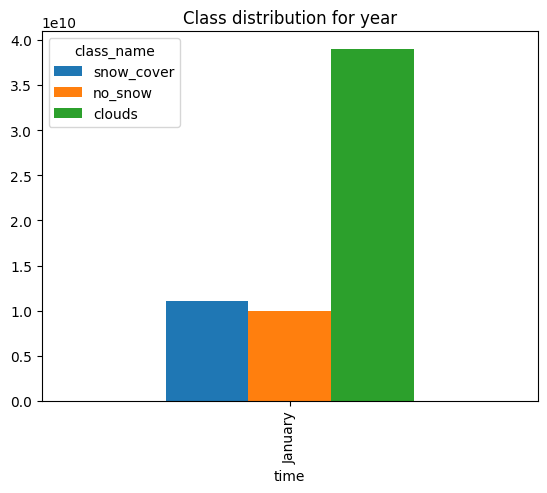

In [133]:
classes_bar_distribution(stats.data_vars['class_distribution_area'], classes_to_plot=['snow_cover', 'no_snow', 'clouds'])

In [ ]:
from pathlib import Path
import xarray as xr
from metrics import MeteoFranceSnowCoverProductCompleteness, NASASnowCoverProductCompleteness
time_series_folder = '../output_folder/completeness_analysis/'
nasa_time_series_name = '2021_SuomiNPP_nasa_time_series_fsc.nc'
meteofrance_time_series_name = '2021_meteofrance_time_series.nc'

meteofrance_time_series_path= Path(f"{time_series_folder}").joinpath(meteofrance_time_series_name)
nasa_time_series_path= Path(f"{time_series_folder}").joinpath(nasa_time_series_name)



ds = xr.open_dataset(meteofrance_time_series_path)#, classes=meteofrance_classes, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
metrics = MeteoFranceSnowCoverProductCompleteness(ds, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
#stats = metrics.year_statistics(months=['january', 'february'], exclude_nodata=True, netcdf_export_path='test_stats.nc', csv_export_path='test_stats.csv')

In [ ]:
ds = xr.open_dataset(nasa_time_series_path)
metrics = NASASnowCoverProductCompleteness(ds, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_v10_epsg4326.tiff')
stats = metrics.year_statistics(months=['january', 'february'], exclude_nodata=True, netcdf_export_path='test_stats.nc', csv_export_path='test_stats.csv')

In [ ]:
from scipy.interpolate import griddata
import numpy as np

latitudes, longitudes = geolocation_data.data_vars['latitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000)), geolocation_data.data_vars['longitude'].isel(number_of_lines=slice(1500,2500), number_of_pixels=slice(5000,6000))
# Define the desired regular latitude-longitude grid
lat_min, lat_max = np.min(latitudes.values), np.max(latitudes.values)
lon_min, lon_max = np.min(longitudes.values), np.max(longitudes.values)
grid_lat, grid_lon = np.mgrid[
    lat_min:lat_max:0.0025,  # Adjust the resolution as needed
    lon_min:lon_max:0.0025,
]

# Interpolate sensor image onto the lat-lon grid
points = np.column_stack((latitudes.values.ravel(), longitudes.values.ravel()))
values = ndsi_snow_cover.isel(lat=slice(1500,2500), lon=slice(5000,6000)).values.ravel()
grid_image = griddata(points, values, (grid_lat, grid_lon), method="cubic")
new_image = xr.DataArray(grid_image, coords={'lat': np.arange(lat_min,lat_max,0.0025), 'lon': np.arange(lon_min,lon_max,0.0025)})
new_snow_cover = georef_data_array(new_image, 'snow_cover', crs_wkt=CRS(4326).to_wkt())
new_snow_cover.to_netcdf('test_v10_snow_cover_crop.nc')

In [ ]:
lon_max